# Evaluating BBRv3 Performance over FABRIC

### Topology

<img src="files/topo.png" width="550px"><br>

# Step 1:  Configuring the environment

Before running this notebook, you will need to configure your environment using the [Configure Environment](../../../configure_and_validate.ipynb) notebook. Please stop here, open and run that notebook, then return to this notebook.

If you are using the FABRIC JupyterHub many of the environment variables will be automatically configured for you.  You will still need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

# Step 2: Importing the FABlib library

In [1]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

In [60]:
try:
    print(f"{fablib.list_sites()}")
except Exception as e:
    print(f"Exception: {e}")

Name,State,Address,Location,PTP Capable,Hosts,CPUs,Cores Available,Cores Capacity,Cores Allocated,Ram Available,Ram Capacity,Ram Allocated,Disk Available,Disk Capacity,Disk Allocated,Basic NIC Available,Basic NIC Capacity,Basic NIC Allocated,P4-Switch Available,P4-Switch Capacity,P4-Switch Allocated,ConnectX-6 Available,ConnectX-6 Capacity,ConnectX-6 Allocated,ConnectX-5 Available,ConnectX-5 Capacity,ConnectX-5 Allocated,NVMe Available,NVMe Capacity,NVMe Allocated,Tesla T4 Available,Tesla T4 Capacity,Tesla T4 Allocated,RTX6000 Available,RTX6000 Capacity,RTX6000 Allocated,A30 Available,A30 Capacity,A30 Allocated,A40 Available,A40 Capacity,A40 Allocated,U280 Available,U280 Capacity,U280 Allocated
EDUKY,Active,"301 Hilltop Avenue,Lexington, KY 40506","(38.0325, -84.502801)",True,18,36,73566,73728,162,8176,8604,428,133082,134082,1000,4294,4445,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INDI,Active,"535 West Michigan Street,Indianapolis, IN 46202","(39.7737312, -86.1674868)",False,3,6,164,384,220,594,1434,840,53118,56618,3500,373,381,8,0,0,0,1,2,1,2,2,0,10,10,0,0,0,0,0,0,0,4,4,0,0,0,0,1,1,0
KANS,Active,"1100 Walnut Street,Kansas City,MO 64106","(39.1004885, -94.5823448)",False,3,6,240,384,144,866,1434,568,61761,64161,2400,376,381,5,0,0,0,2,2,0,2,2,0,10,10,0,0,0,0,0,0,0,4,4,0,0,0,0,1,1,0
WASH,Active,"1755 Old Meadow Road, 22102","(38.9208836, -77.2111974)",False,3,6,187,384,197,978,1434,456,60141,64161,4020,283,381,98,0,0,0,1,2,1,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,1,1,0
GATECH,Active,"760 West Peachtree Street NW,Atlanta, GA 30308","(33.7753991, -84.3875488)",True,5,10,450,640,190,1950,2390,440,55439,58849,3410,619,635,16,0,0,0,2,2,0,2,4,2,16,16,0,0,0,0,0,0,0,6,7,1,0,0,0,1,1,0
CERN,Active,"Meyrin site, Auvergne-Rhone-Alpes, Metropolitan France, 01280, France","(46.2338702, 6.0469869)",True,6,12,329,768,439,1740,2868,1128,46363,54003,7640,697,762,65,0,0,0,2,6,4,4,4,0,21,22,1,0,0,0,0,0,0,4,5,1,2,2,0,0,0,0
UCSD,Active,"10100 Hopkins Drive,CA 92093","(32.8886802, -117.239324)",True,5,10,338,640,302,1190,2390,1200,54087,58717,4630,622,635,13,1,1,0,2,2,0,4,4,0,16,16,0,4,4,0,4,6,2,0,0,0,0,0,0,1,1,0
BRIST,Active,"Beacon House,Queens Road,Bristol, BS8 1QU, UK","(51.457119, -2.607297)",True,3,6,264,384,120,1050,1434,384,53698,56618,2920,373,381,8,0,0,0,3,3,0,2,2,0,10,10,0,0,0,0,0,0,0,3,4,1,0,0,0,0,0,0
PSC,Active,"4350 Northern Pike,Monroeville, PA 15146","(40.4343887, -79.750207)",True,3,6,232,384,152,850,1434,584,54198,56618,2420,375,381,6,0,0,0,1,2,1,2,2,0,10,10,0,0,0,0,0,0,0,4,4,0,0,0,0,1,1,0
STAR,Active,"710 North Lakeshore Drive, 60611","(42.2359989, -88.1575427)",True,6,12,314,768,454,1844,2820,976,106156,109696,3540,709,762,53,1,1,0,1,2,1,4,6,2,19,20,1,6,6,0,6,6,0,0,0,0,0,0,0,1,1,0


# Step 3: Creating the experiment slice

The following creates a node with basic compute and networking capabilities. You build a slice by creating a new slice and adding resources to the slice. After you build the slice, you must submit a request for the slice to be instantiated.   

### 3.1 Configuring Slice Parameters

In [2]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

# Slice 
slice_name = 'bbr3_test'

#[site1,site2] = fablib.get_random_sites(count=2)
site1="NEWY"
site2="SALT"
print(f"Sites: {site1},{site2}")

# Switches
s1_name = "s1"
s2_name = "s2"

switch_cores = 2
switch_ram = 8
switch_disk = 20

# Hosts
h1_name = "h1"
h2_name = "h2"

h1_subnet=IPv4Network('172.16.0.0/16')
h1_addr=IPv4Address('172.16.0.10')
s1_addr1=IPv4Address('172.16.255.254')

h2_subnet=IPv4Network('172.17.0.0/16')
h2_addr=IPv4Address('172.17.0.10')
s2_addr1=IPv4Address('172.17.255.254')

s1_subnet=IPv4Network('192.168.12.0/30')
s1_addr2=IPv4Address('192.168.12.1')

s2_subnet=IPv4Network('192.168.12.0/30')
s2_addr2=IPv4Address('192.168.12.2')

host_cores = 2
host_ram = 8
host_disk = 20

net_h1_name = 'net_h1'
net_h2_name = 'net_h2'

net_s1_s2_name = 'net_s1_s2'

# All node properties
image = 'default_ubuntu_22'

Sites: NEWY,SALT


### 3.2 Creating the Slice

This step takes around 3-4 minutes

In [3]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)

    # Add switch node s1
    s1 = slice.add_node(name=s1_name, site=site1,  image=image, 
                        cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s1.set_capacities(cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s1_iface_1 = s1.add_component(model='NIC_Basic', name="s1_switch_nic1").get_interfaces()[0]
    s1_iface_2 = s1.add_component(model='NIC_Basic', name="s1_switch_nic2").get_interfaces()[0]

     # Add switch node s1
    s2 = slice.add_node(name=s2_name, site=site2,  image=image, 
                        cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s2.set_capacities(cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s2_iface_1 = s2.add_component(model='NIC_Basic', name="s2_switch_nic1").get_interfaces()[0]
    s2_iface_2 = s2.add_component(model='NIC_Basic', name="s2_switch_nic2").get_interfaces()[0]
    
    # Add host node h1
    h1 = slice.add_node(name=h1_name, site=site1, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h1_iface = h1.add_component(model='NIC_Basic', name="h1_nic").get_interfaces()[0]
    
    # Add host node h2
    h2 = slice.add_node(name=h2_name, site=site2, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h2_iface = h2.add_component(model='NIC_Basic', name="h2_nic").get_interfaces()[0]
    
    #Add host networks 
    host_net1 = slice.add_l2network(name=net_h1_name, interfaces=[h1_iface, s1_iface_1])
    switch_net1 = slice.add_l2network(name=net_s1_s2_name, interfaces=[s1_iface_2, s2_iface_2])
    host_net2 = slice.add_l2network(name=net_h2_name, interfaces=[h2_iface, s2_iface_1])
    
    #Submit Slice Request
    slice.submit() 
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()


Retry: 11, Time: 280 sec


ID,877b5112-a513-45f6-a45a-fdc796ab65f6
Name,bbr3_test
Lease Expiration (UTC),2024-10-30 16:58:35 +0000
Lease Start (UTC),2024-10-29 16:58:35 +0000
Project ID,8eaa3ec2-65e7-49a3-8c09-e1761141a6ad
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
02e47316-5212-4893-a0bf-c799b2f3f572,h1,2,8,100,default_ubuntu_22,qcow2,newy-w2.fabric-testbed.net,NEWY,ubuntu,2001:400:a100:3040:f816:3eff:feb1:1a9d,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:feb1:1a9d,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
dee25070-e4c3-449f-aaf9-5851bf7d8bfc,h2,2,8,100,default_ubuntu_22,qcow2,salt-w2.fabric-testbed.net,SALT,ubuntu,2001:400:a100:3010:f816:3eff:feeb:c943,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3010:f816:3eff:feeb:c943,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
b317cc5d-ec0b-4913-a6cf-64b62f96a4c7,s1,2,8,100,default_ubuntu_22,qcow2,newy-w2.fabric-testbed.net,NEWY,ubuntu,2001:400:a100:3040:f816:3eff:fe6e:714a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:fe6e:714a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
bd96eeee-ceea-4a8a-be0c-eef852af6bca,s2,2,8,100,default_ubuntu_22,qcow2,salt-w2.fabric-testbed.net,SALT,ubuntu,2001:400:a100:3010:f816:3eff:fed4:a579,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3010:f816:3eff:fed4:a579,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
afe1f95e-985d-401d-8415-42adc38018d5,net_h1,L2,L2Bridge,NEWY,None,None,Active,
9a0c85be-946a-4382-9102-651e9d9c93c7,net_h2,L2,L2Bridge,SALT,None,None,Active,
2ea3bdcd-cb47-4d23-a653-0daf355a2226,net_s1_s2,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
s1-s1_switch_nic2-p1,p1,s1,net_s1_s2,100,config,,06:66:28:AA:10:97,enp7s0,enp7s0,fe80::466:28ff:feaa:1097,4,HundredGigE0/0/0/7
s1-s1_switch_nic1-p1,p1,s1,net_h1,100,config,,06:AB:82:AA:BF:45,enp8s0,enp8s0,fe80::4ab:82ff:feaa:bf45,4,HundredGigE0/0/0/7
s2-s2_switch_nic2-p1,p1,s2,net_s1_s2,100,config,,02:FD:A3:DB:59:80,enp7s0,enp7s0,fe80::fd:a3ff:fedb:5980,4,HundredGigE0/0/0/7
s2-s2_switch_nic1-p1,p1,s2,net_h2,100,config,,06:56:74:17:A9:C0,enp8s0,enp8s0,fe80::456:74ff:fe17:a9c0,4,HundredGigE0/0/0/7
h1-h1_nic-p1,p1,h1,net_h1,100,config,,0E:0F:46:67:B8:1F,enp7s0,enp7s0,fe80::c0f:46ff:fe67:b81f,4,HundredGigE0/0/0/7
h2-h2_nic-p1,p1,h2,net_h2,100,config,,06:72:BC:E6:0F:21,enp7s0,enp7s0,fe80::472:bcff:fee6:f21,4,HundredGigE0/0/0/7



Time to print interfaces 304 seconds


### 3.3 Installing BBRv3 Kernel Module

In [4]:
h1 = slice.get_node(name="h1")     
h1.upload_file('kernel_module/linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.upload_file('kernel_module/linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.execute("sudo dpkg -i linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("sudo dpkg -i linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("echo 'net.ipv4.tcp_congestion_control=bbr' | sudo tee -a /etc/sysctl.conf")
h1.execute("sudo rm *.deb")
h1.execute("sudo sysctl -p")
#h1.execute("sysctl net.ipv4.tcp_congestion_control")
h1.execute("sudo reboot")

Selecting previously unselected package linux-headers-6.4.0-bbrv3.
(Reading database ... 64379 files and directories currently installed.)
Preparing to unpack linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Selecting previously unselected package linux-image-6.4.0-bbrv3.
(Reading database ... 74627 files and directories currently installed.)
Preparing to unpack linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
 update-initramfs: Generating /boot/initrd.img-6.4.0-bbrv3
  Sourcing file `/etc/default/grub'
  Sourcing file `/etc/default/grub.d/50-cloudimg-settings.cfg'
  Sourcing file `/etc/default/grub.d/init-select.cfg'
  Generating grub configuration file ...
  Found linux image: /boot/vmlinuz-6.4.0-bbrv3
  Found 

('', '')

### 3.4 Verifying the Kernel Module Installation

In [5]:
h1.execute("uname -a")
h1.execute("sysctl net.ipv4.tcp_available_congestion_control")

Linux h1 6.4.0-bbrv3 #1 SMP PREEMPT_DYNAMIC Tue Oct  8 11:37:28 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
net.ipv4.tcp_available_congestion_control = reno bbr bbr1 cubic


('net.ipv4.tcp_available_congestion_control = reno bbr bbr1 cubic\n', '')

### 3.4 Printing the Node SSH Commands

In [6]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node.get_name()}: {node.get_ssh_command()}")
except Exception as e:
    print(f"Exception: {e}")

s1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:fe6e:714a
s2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3010:f816:3eff:fed4:a579
h1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:feb1:1a9d
h2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3010:f816:3eff:feeb:c943


# Step 4 Configuring Nodes

### 4.1 Configuring Updates and Packages

In [7]:
config_threads = {}

In [8]:
host_config_script = "sudo apt-get update -qq && sudo apt-get -y install && sudo apt-get -y install net-tools -qq && sudo apt-get -y install iperf3 -qq" 

try: 
    h1 = slice.get_node(name=h1_name)
    h1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h1/' /etc/hosts")
    if type(ip_address(h1.get_management_ip())) is IPv6Address:
        h1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    h1_os_iface = h1.get_interface(network_name=net_h1_name)
    h1_os_iface.ip_addr_add(addr=h1_addr, subnet=h1_subnet)
    h1_config_thread = h1.execute_thread(host_config_script)
    config_threads[h1] = h1_config_thread
    
    h2 = slice.get_node(name=h2_name)
    h2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h2/' /etc/hosts")
    if type(ip_address(h2.get_management_ip())) is IPv6Address:
        h2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
    h2_os_iface = h2.get_interface(network_name=net_h2_name)
    h2_os_iface.ip_addr_add(addr=h2_addr, subnet=h2_subnet)
    h2_config_thread = h2.execute_thread(host_config_script)
    config_threads[h2] = h2_config_thread

    s1 = slice.get_node(name=s1_name)  
    s1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost s1/' /etc/hosts")
    if type(ip_address(s1.get_management_ip())) is IPv6Address:
        s1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    s1_os_iface = s1.get_interface(network_name=net_h1_name)
    s1_os_iface.ip_addr_add(addr=s1_addr1, subnet=h1_subnet)
    s1_os_iface = s1.get_interface(network_name=net_s1_s2_name)
    s1_os_iface.ip_addr_add(addr=s1_addr2, subnet=s1_subnet)
    s1_config_thread = s1.execute_thread(host_config_script)
    config_threads[s1] = s1_config_thread

    s2 = slice.get_node(name=s2_name) 
    s2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost s2/' /etc/hosts")
    if type(ip_address(s2.get_management_ip())) is IPv6Address:
        s2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    s2_os_iface = s2.get_interface(network_name=net_h2_name)
    s2_os_iface.ip_addr_add(addr=s2_addr1, subnet=h2_subnet)   
    s2_os_iface = s2.get_interface(network_name=net_s1_s2_name)
    s2_os_iface.ip_addr_add(addr=s2_addr2, subnet=s2_subnet)
    s2_config_thread = s2.execute_thread(host_config_script)
    config_threads[s2] = s2_config_thread

except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

### 4.2 Installing Mininet

In [9]:
h1.execute("git clone https://github.com/mininet/mininet  &> /dev/null")
h1.execute("cd mininet")
h1.execute("git checkout -b mininet-2.3.1b4")
h1.execute("cd ..")
h1.execute("mininet/util/install.sh -a &> /dev/null")

h2.execute("git clone https://github.com/mininet/mininet &> /dev/null")
h2.execute("cd mininet")
h2.execute("git checkout -b mininet-2.3.1b4")
h2.execute("cd ..")
h2.execute("mininet/util/install.sh -a &> /dev/null")

 fatal: not a git repository (or any of the parent directories): .git
  fatal: not a git repository (or any of the parent directories): .git
 

('', '')

### 4.3 Configuring Default Routes in h1 and h2 and Static Routes in S1 and S2

In [10]:
h1.execute("sudo ifconfig enp7s0 up")
h1.execute("sudo ip route add 172.17.0.0/16 via 172.16.255.254")
h2.execute("sudo ifconfig enp7s0 up")
h2.execute("sudo ip route add 172.16.0.0/16 via 172.17.255.254")

s1.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")
s2.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")

s1.execute("sudo ip route add 172.17.0.0/16 via 192.168.12.2")
s2.execute("sudo ip route add 172.16.0.0/16 via 192.168.12.1")

net.ipv4.conf.all.forwarding = 1
net.ipv4.conf.all.forwarding = 1


('', '')

### 4.3 Setting TCP Send and Receive Buffer Sizes in 

In [11]:
h1.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

h2.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000
net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000


('net.ipv4.tcp_rmem = 1024 87380 200000000\n', '')

# Step 5 Misc Scripts

### 5.1 Printing Slice Attributes

In [44]:
try:
    slice = fablib.get_slice(name=slice_name)
    print(f"{slice}")
except Exception as e:
    print(f"Exception: {e}")

-----------  ------------------------------------
Slice Name   bbr3_test
Slice ID     55e0e573-a5e4-4a64-ac20-9b1aade02371
Slice State  StableOK
Lease End    2024-10-15 22:06:26 +0000
-----------  ------------------------------------


### 5.2 Printing the Node Attributes

In [6]:
try:
    slice = fablib.get_slice(name=slice_name)

    print(f"{slice.list_nodes()}")
except Exception as e:
    print(f"Exception: {e}")

Exception: Unable to find slice "bbr3_test" for this project. Check slice name spelling and project id.


### 5.3 Printing the Node Details

In [45]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node}")
except Exception as e:
    print(f"Exception: {e}")

-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
ID                 f3e35fad-94ea-4070-a58c-f2579d54bf7d
Name               s1
Cores              2
RAM                8
Disk               100
Image              default_ubuntu_22
Image Type         qcow2
Host               newy-w2.fabric-testbed.net
Site               NEWY
Management IP      2001:400:a100:3040:f816:3eff:fe2e:e3a6
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:fe2e:e3a6
-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
-----------------  --------------------------------------------------------------------------------------------------------------------------------

#### 5.4 Printing the Interfaces

In [46]:
try:
    slice = fablib.get_slice(name=slice_name)
    
    print(f"{slice.list_interfaces()}")
except Exception as e:
    print(f"Exception: {e}")

Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
s1-s1_switch_nic1-p1,p1,s1,net_h1,100,config,,0E:62:1A:D6:09:B9,enp7s0,enp7s0,172.16.0.1,4,HundredGigE0/0/0/7
s1-s1_switch_nic2-p1,p1,s1,net_s1_s2,100,config,,12:BA:40:30:C3:36,enp8s0,enp8s0,192.168.12.1,4,HundredGigE0/0/0/7
s2-s2_switch_nic2-p1,p1,s2,net_s1_s2,100,config,,06:D4:16:2C:10:10,enp8s0,enp8s0,192.168.12.2,6,HundredGigE0/0/0/5
s2-s2_switch_nic1-p1,p1,s2,net_h2,100,config,,06:C9:EE:46:AB:31,enp7s0,enp7s0,172.17.0.1,6,HundredGigE0/0/0/5
h1-h1_nic-p1,p1,h1,net_h1,100,config,,16:24:75:91:49:87,enp7s0,enp7s0,172.16.0.10,4,HundredGigE0/0/0/7
h2-h2_nic-p1,p1,h2,net_h2,100,config,,0E:1E:17:82:0A:70,enp7s0,enp7s0,172.17.0.10,6,HundredGigE0/0/0/5


### 5.5 Deleting Slice

In [2]:
slice.delete()

AttributeError: type object 'slice' has no attribute 'delete'

# 6 Inter-protocol Fairness

## 6.1 Pre-test Configuration

### 6.1.1 Launching Mininet Topology in h1 and h2

In [12]:
#h1 = slice.get_node(name=h1_name)
#h2 = slice.get_node(name=h2_name)
num_hosts=10

h1.upload_file('scripts/topo_h1.py', 'topo_h1.py')
h2.upload_file('scripts/topo_h2.py', 'topo_h2.py')

h1.execute('sudo mn -c &> /dev/null')
h2.execute('sudo mn -c &> /dev/null')

h1.execute('mkdir results')
h2.execute('mkdir results')

# h1.execute(f'sudo python3 topo_h1.py {num_hosts} &')
# h2.execute(f'sudo python3 topo_h2.py {num_hosts} &')

('', '')

### !!!Run the scripts manually in the VMS

sudo python3 topo_h1.py {num_hosts}

### 6.1.2 Adding the VM's Port to Switch S1

In [13]:
h1.execute('sudo ovs-vsctl add-port s1 enp7s0')
h2.execute('sudo ovs-vsctl add-port s1 enp7s0')

('', '')

### 6.1.3 Configure static Routes in the Mininet hosts

In [40]:
for i in range(1, num_hosts + 1):
    h1.execute(f"mininet/util/m hs{i} route add default gw 172.16.255.254")
    h2.execute(f"mininet/util/m hr{i} route add default gw 172.17.255.254")

### 6.1.4 Populating the ARP tables in the Mininet Hosts

In [41]:
for i in range(1, num_hosts + 1):
    h1.execute(f"mininet/util/m hs{i} ping 172.17.0.{i} -c 1", quiet=True)
    h2.execute(f"mininet/util/m hr{i} ping 172.16.0.{i} -c 1", quiet=True)

PING 172.17.0.1 (172.17.0.1) 56(84) bytes of data.

--- 172.17.0.1 ping statistics ---
1 packets transmitted, 0 received, 100% packet loss, time 0ms

PING 172.16.0.1 (172.16.0.1) 56(84) bytes of data.
64 bytes from 172.16.0.1: icmp_seq=1 ttl=62 time=54.5 ms

--- 172.16.0.1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 54.523/54.523/54.523/0.000 ms
PING 172.17.0.2 (172.17.0.2) 56(84) bytes of data.

--- 172.17.0.2 ping statistics ---
1 packets transmitted, 0 received, 100% packet loss, time 0ms

PING 172.16.0.2 (172.16.0.2) 56(84) bytes of data.
64 bytes from 172.16.0.2: icmp_seq=1 ttl=62 time=54.5 ms

--- 172.16.0.2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 54.482/54.482/54.482/0.000 ms
PING 172.17.0.3 (172.17.0.3) 56(84) bytes of data.

--- 172.17.0.3 ping statistics ---
1 packets transmitted, 0 received, 100% packet loss, time 0ms

PING 172.16.0.3 (172.16.0.3) 56(84) 

### 6.1.4 Starting the iPerf3 Servers in h2

In [69]:
for i in range(1, num_hosts + 1):
    h2.execute_thread(f"mininet/util/m hr{i} iperf3 -s")

## 6.2 Running the Test

### 6.2.1 Starting the iPerf3 clients

In [70]:
for i in range(1, num_hosts + 1):
    h1.execute(f"mininet/util/m hs{i} iperf3 -c 172.17.0.{i} -J > results/hs{i}_out.json &")

### 6.2.2 Get the JSON Files

In [71]:
for i in range(1, num_hosts + 1):
    h1.download_file(f"results/hs{i}_out.json",f"results/hs{i}_out.json")

## 6.3 Plotting the Results

### 6.3.1 Plot as a Function of Time

/tmp/ipykernel_160/4248212304.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="lower right")


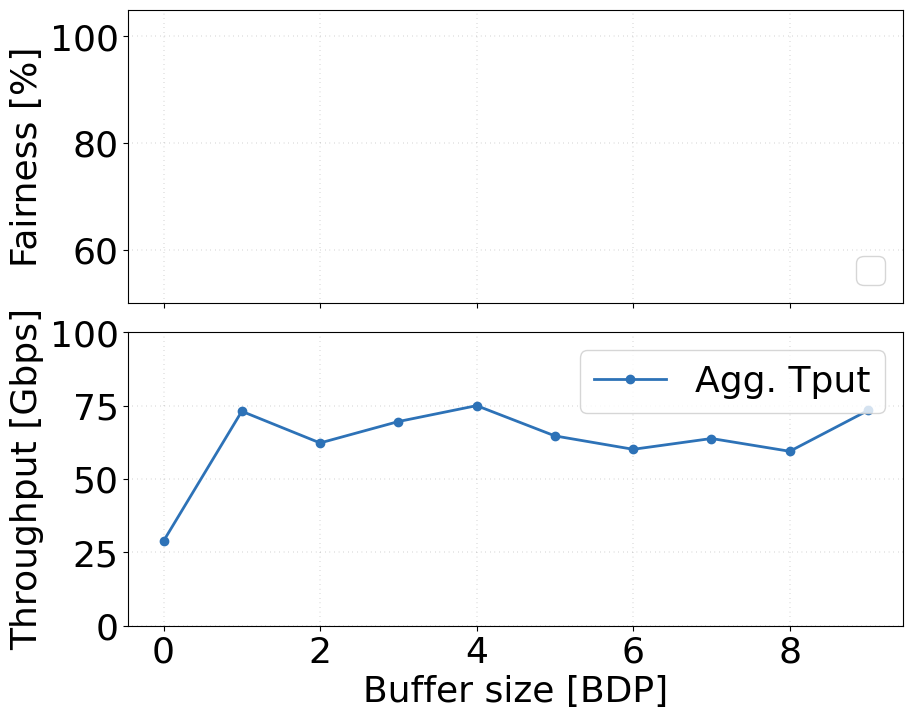

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib

# Load throughput data from JSON
def extract_iperf_timming(filename):   
    with open(filename) as f:
        data = json.load(f)
    dur = int(data['end']['sum_sent']['end'])
    result = []
    for i in range(0, dur):
       result.append(float(data['intervals'][i]['sum']['bits_per_second']) / 1e9)
    
    return result

# Plot setup for fair and clean visuals
def setup_plot(font_size=26):
    font = {'family': 'normal', 'weight': 'normal', 'size': font_size}
    matplotlib.rc('font', **font)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.1)
    for ax in axes:
        ax.grid(True, which="both", lw=0.3, linestyle=(0, (1, 10)), color='black')
    return fig, axes

# Calculate fairness based on throughput
def calculate_fairness(cubic, bbr3):
    return [
        100 * (c + b) ** 2 / (2 * (c ** 2 + b ** 2))
        for c, b in zip(cubic, bbr3)
    ]

# Main plotting function for experiment results
def plot_results(throughput, filename="output.pdf"):
    #fairness = calculate_fairness(cubic, bbr3)
    fig, axes = setup_plot()
    t = list(range(0, len(throughput)))
    # Plotting fairness and throughput
   
    axes[1].plot(t, throughput, '#2D72B7', linewidth=2, label='Agg. Tput', marker='o')

    # Set labels and legends
    axes[0].set_ylabel('Fairness [%]')
    axes[1].set_ylabel('Throughput [Gbps]')
    axes[1].set_xlabel('Buffer size [BDP]')
    axes[0].legend(loc="lower right")
    axes[1].legend(loc="upper right", ncol=2)
    axes[0].set_ylim([50, 105])
    axes[1].set_ylim([0, 100])

    fig.savefig(filename, bbox_inches='tight')

def main():
    th = []
    # Extract the Throughput of each flow
    for i in range(1, num_hosts + 1):
        th.append(extract_iperf_timming(f"results/hs{i}_out.json"))

    # 
    agg_th = [sum(column) for column in zip(*th)]
    plot_results(agg_th, filename="output.pdf")
        
        
    #setup_plot(font_size=26)

            
if __name__ == '__main__':
    main()
